# Formato DICOM

*Digital Imaging and Communications in Medicine*

Estándar internacional para transmitir, almacenar, recuperar, imprimir, procesar y visualizar información de imágenes médicas

Integra distintos formatos resultantes de dispositivos de adquisición de imágenes

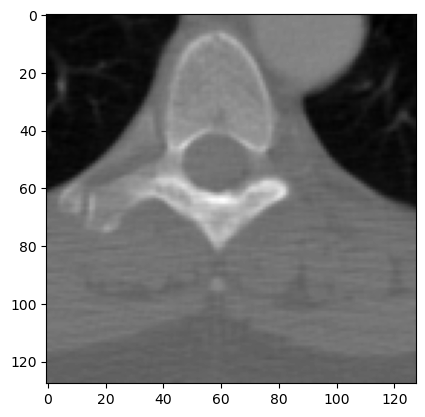

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pydicom import examples
from pydicom import dcmread
from matplotlib.patches import Rectangle

ds = examples.ct
plt.imshow(ds.pixel_array, cmap=plt.gray())

## Formato

Datos de un archivo DICOM (.dcm)

In [2]:
# VinDR-Mammo dataset, used for learning purposes
dicom_sample = './data/sample/'

ds = dcmread(dicom_sample + '1/15de2fd7289d8371a8273f87a8393568.dicom')
ds.file_meta

C:\Users\Chef\AppData\Roaming\Python\Python312\site-packages\pydicom\valuerep.py:440: UserWarning: Invalid value for VR UI: '15de2fd7289d8371a8273f87a8393568'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


(0002,0000) File Meta Information Group Length  UL: 158
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital Mammography X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 15de2fd7289d8371a8273f87a8393568
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.3.4
(0002,0013) Implementation Version Name         SH: 'RadiAnt-2020.1.1'

In [3]:
print(f'Resolución: {ds.pixel_array.shape[0]}x{ds.pixel_array.shape[1]}')

Resolución: 3518x2800


In [4]:
dicom_df = pd.read_csv('./data/finding_annotations.csv')

dicom_df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


In [5]:
print(dicom_df.shape)

(20486, 16)


## Visualización

Se muestra un ejemplo de un caso con Bi-rads 1, y otro con Bi-rads 5

In [6]:
def get_dcm(path):
    dcm = []
    for idx, file in enumerate(os.listdir(path)):
        dcm.append(file)
    return dcm

In [7]:
def dcm_show_sample(idx, title=None, box=False):
    title = '' if title is None else title
    route = dicom_sample + str(idx) + '/'
    dcm_list = get_dcm(route)
    
    f, ax = plt.subplots(1, 4, figsize=(12, 12))
    f.suptitle(title, y=0.645)

    for i, path in enumerate(dcm_list):
        img = dcmread(route + path)
        
        entry = dicom_df[dicom_df['image_id'] == path.split('.')[0]]
        lat = np.squeeze(entry['laterality'].iloc[0])
        vp = np.squeeze(entry['view_position'].iloc[0])
        
        if box is True and entry['finding_categories'].iloc[0] != "['No Finding']":
            x = entry['xmin'].iloc[0]
            y = entry['ymin'].iloc[0]
            w = entry['xmax'].iloc[0] - x 
            h = entry['ymax'].iloc[0] - y 
            
            rect = Rectangle((x, y), w, h, color=(0, 1, 0), fill=False)
            ax[i].add_patch(rect)
        
        ax[i].set_title(f'{lat}-{vp}')
        ax[i].axis('off')
        ax[i].imshow(img.pixel_array, cmap=plt.gray())

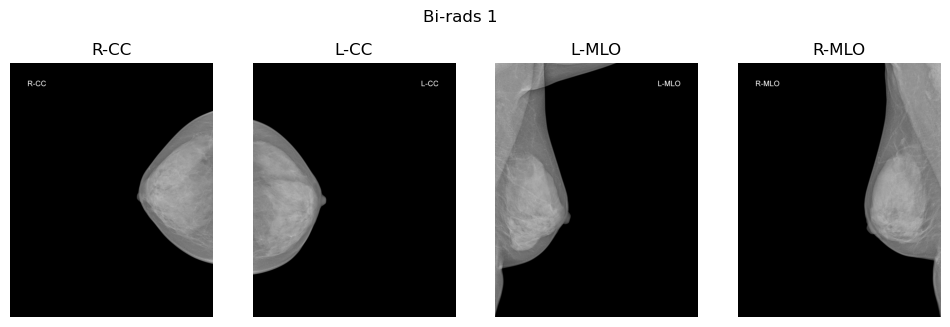

In [8]:
dcm_show_sample(1, 'Bi-rads 1')

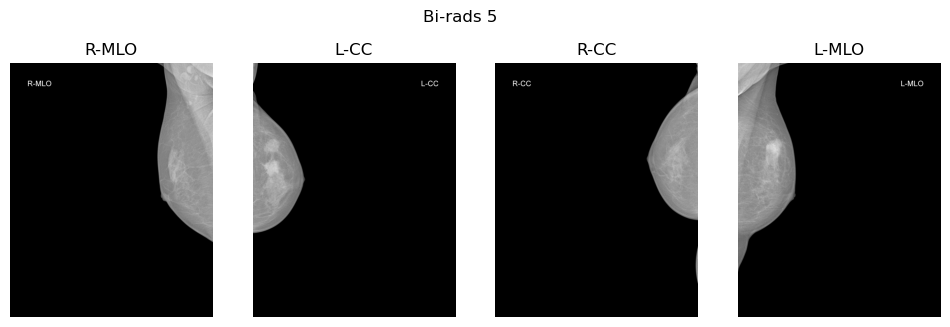

In [9]:
dcm_show_sample(2, 'Bi-rads 5')

## Hallazgos

En el dataset hay anotaciones sobre los hallazgos realizados en los estudios, contienen la categoría y las posiciones de un rectángulo *(bounding box)* que contiene el área del hallazgo

In [10]:
dicom_df['finding_categories'].head()

0                        ['Mass']
1                        ['Mass']
2            ['Global Asymmetry']
3            ['Global Asymmetry']
4    ['Architectural Distortion']
Name: finding_categories, dtype: object

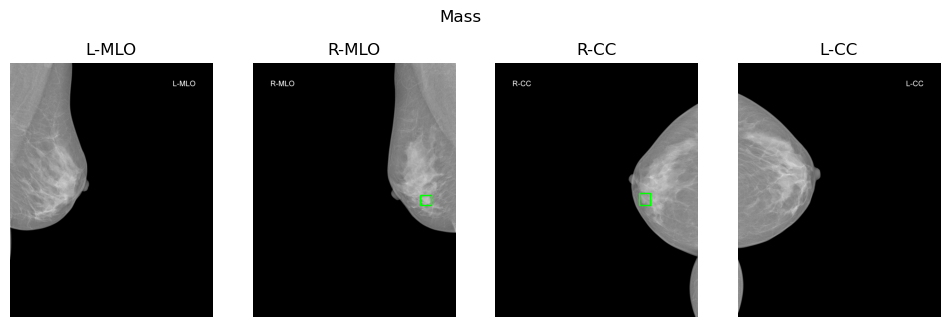

In [11]:
dcm_show_sample('Mass', 'Mass', True)

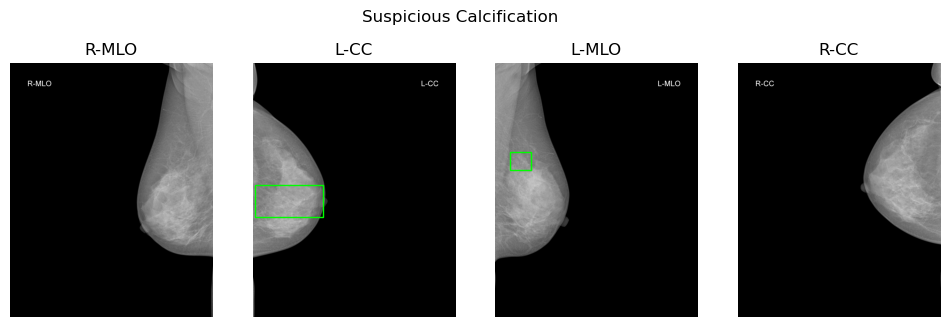

In [12]:
dcm_show_sample('Suspicious Calcification', 'Suspicious Calcification', True)

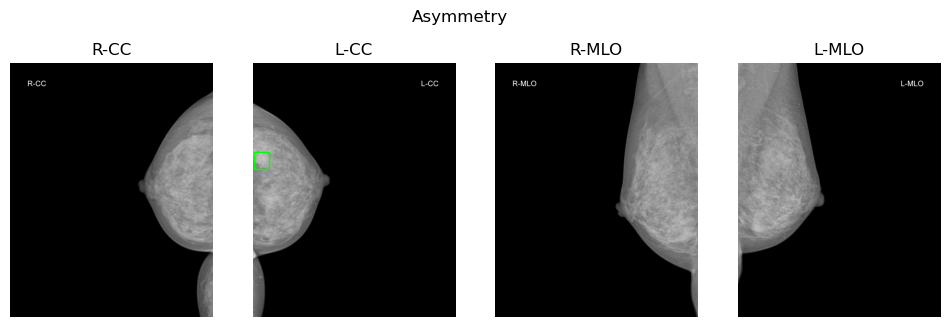

In [13]:
dcm_show_sample('Asymmetry', 'Asymmetry', True)

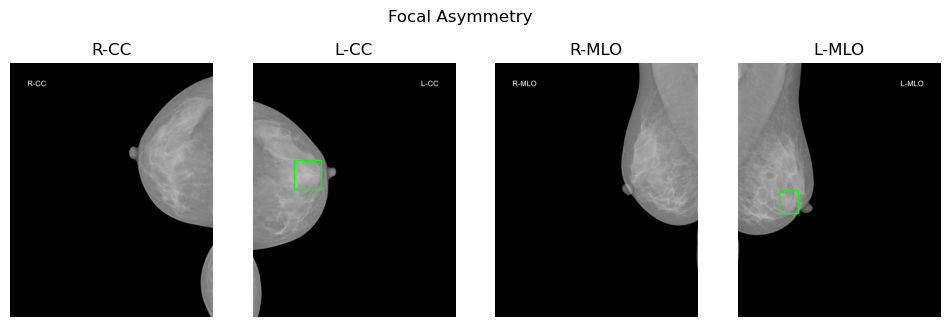

In [14]:
dcm_show_sample('Focal Asymmetry', 'Focal Asymmetry', True)

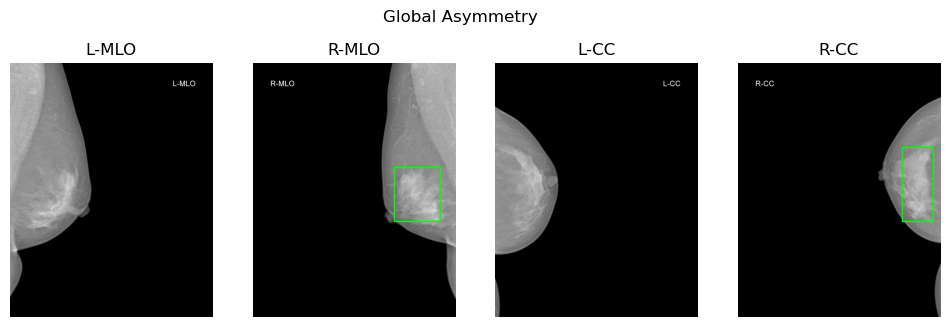

In [15]:
dcm_show_sample('Global Asymmetry', 'Global Asymmetry', True)

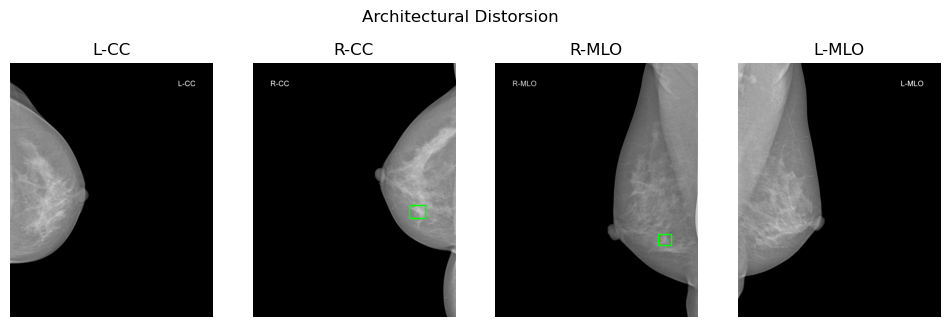

In [16]:
dcm_show_sample('Architectural Distorsion', 'Architectural Distorsion', True)

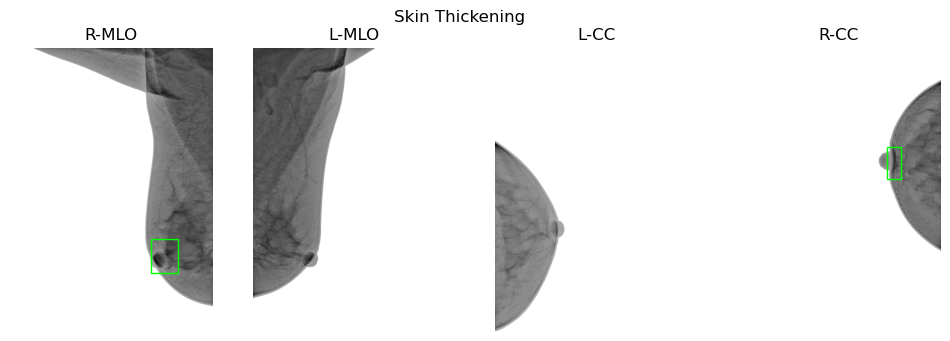

In [17]:
dcm_show_sample('Skin Thickening', 'Skin Thickening', True)

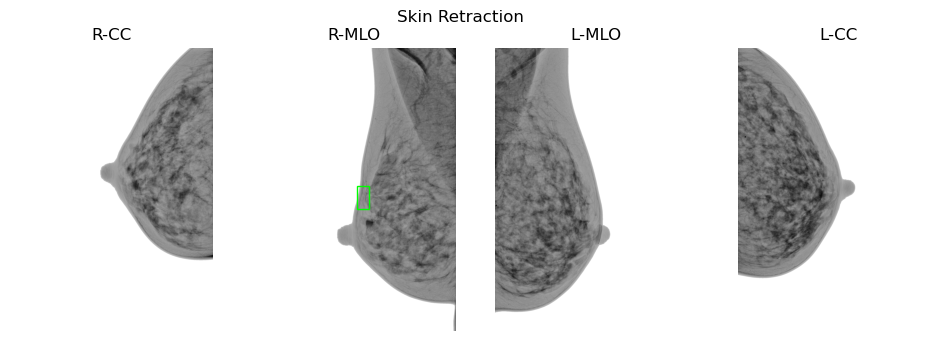

In [18]:
dcm_show_sample('Skin Retraction', 'Skin Retraction', True)

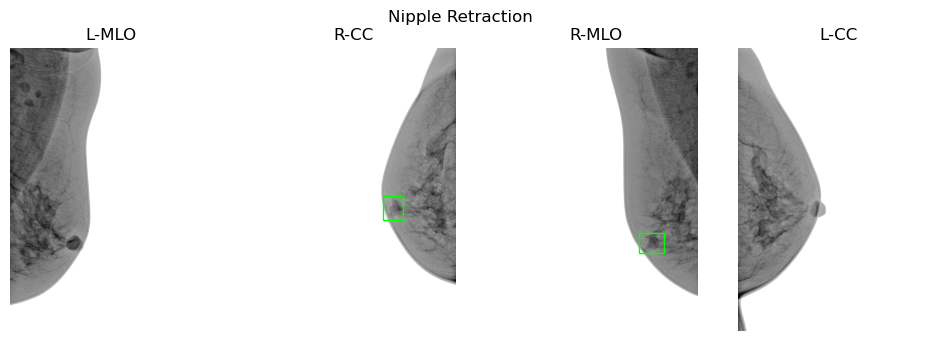

In [19]:
dcm_show_sample('Nipple Retraction', 'Nipple Retraction', True)

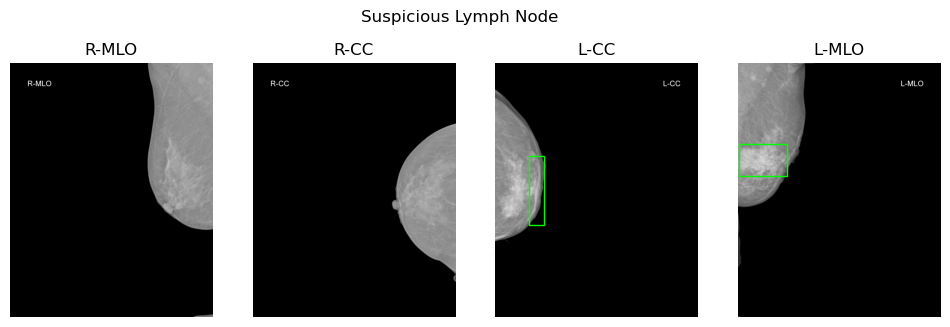

In [20]:
dcm_show_sample('Suspicious Lymph Node', 'Suspicious Lymph Node', True)